# This notebook helps you to do several things:
1) Find your optimal learning rate
https://docs.fast.ai/callbacks.html#LRFinder
2) 

In [1]:
%reload_ext autoreload
%autoreload 2

import fastai
from fastai.callbacks import *

from torch.utils.data import Dataset, DataLoader
from models import UNet2d_assembled
import numpy as np
import torch
from fastai.vision import *

torch.backends.cudnn.benchmark = True

In [2]:
DEVICE = 'cuda'
OS = 'Windows'



In [6]:
# GET DATASET
class CMRIreconDataset(Dataset):
    """CMRIrecon dataset."""
    def __init__(self, input_file_path, target_file_path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.inputs = np.load(input_file_path)
        self.targets = np.load(target_file_path)

    def __len__(self):
#         print("print length of inputs",len(self.inputs))
#         print("print shape of inputs",np.shape(self.inputs))
        return len(self.inputs)

    def __getitem__(self, idx):

#         sample = {'input': self.inputs[idx], 'target': self.targets[idx]}
        X = self.inputs[idx].astype(np.float32)
        Y = self.targets[idx].astype(np.float32)
        return  X, Y



In [7]:


if OS == 'Linux':
    CMRIdataset = CMRIreconDataset(
        input_file_path = \
        '/home/nw92/reconproject_data/input_data.npy', \
        target_file_path = \
        '/home/nw92/reconproject_data/target_data.npy')

elif OS == 'Windows':
    CMRIdataset = CMRIreconDataset(
        input_file_path = \
        'C:/Users/littl/Documents/PythonScripts/reconproject_data/input_data.npy', \
        target_file_path = \
        'C:/Users/littl/Documents/PythonScripts/reconproject_data/target_data.npy')

else:
    print("Please use valid COMPUTER.\nOptions:\t\'Windows\'\t\'Linux\'")


# SPLIT DATASET INTO TRAIN, VAL AND TEST #####################################
# CMRIdataset = train_dataset + test_dataset
print("\nSplit dataset into train data (80%) and test data (20%)...\n")
train_size = int(0.8 * len(CMRIdataset))
test_size = len(CMRIdataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(CMRIdataset, [train_size, test_size])

# train_dataset = train_dataset + val_dataset
print("\nSplit train data into train data (80%) and val data (20%)...\n")
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


print("Load train_dl, val_dl and test_dl...")
# load train set
train_dl = DataLoader(train_dataset, batch_size=16,
                    shuffle=True, num_workers=0)
# load validation set
valid_dl = DataLoader(val_dataset, batch_size=16,
                    shuffle=True, num_workers=0)
# load test set
test_dl = DataLoader(test_dataset, batch_size=16,
                    shuffle=True, num_workers=0)

print("train_dl, val_dl and test_dl loaded!")


# # DEFINE DATABUNCH TO FEED THE MODEL
data = DataBunch(train_dl,
        valid_dl,
        test_dl,
        device=DEVICE,
        # dl_tfms:Optional[Collection[Callable]]=None,
        # path:PathOrStr='.',
        # collate_fn:Callable='data_collate',
        # no_check:bool=False
        )


# data.show_batch(rows=4)


Split dataset into train data (80%) and test data (20%)...


Split train data into train data (80%) and val data (20%)...

Load train_dl, val_dl and test_dl...
train_dl, val_dl and test_dl loaded!


In [8]:
# DEFINE LEARNER
loss_func = nn.MSELoss()
metrics = mean_absolute_error
model = UNet2d_assembled.UNet2D(20) #20 channels

learn = Learner(data = data,
        model = model,
        # opt_func:Callable='Adam',
        loss_func = loss_func,
        metrics = metrics,
#         callback_fns=[CSVLogger],
        # true_wd:bool=True,
        # bn_wd:bool=True,
        # wd:Floats=0.01,
        # train_bn:bool=True,
        # path:str=None,
        # model_dir:PathOrStr='models',
        # callback_fns:Collection[Callable]=None,
        # callbacks:Collection[Callback]=<factory>,
        # layer_groups:ModuleList=None,
        # add_time:bool=True,
        # silent:bool=None
        )

# learn.summary()
learn.lr_find(start_lr=1e-07, end_lr=10)
# learn = cnn_learner(data, models.resnet18, metrics=accuracy)
# learn.fit(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


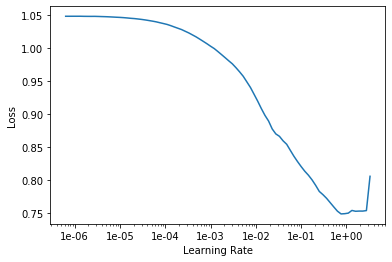

In [9]:
learn.recorder.plot()


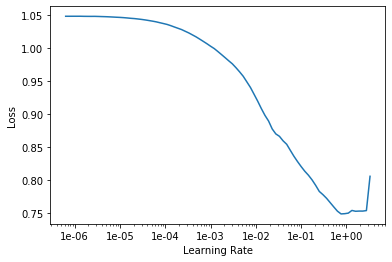

In [10]:
learn.recorder.plot()

In [11]:
lr = 1.5e-2

In [13]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.674943,16113.897461,75.433685,00:11
1,0.522100,0.491363,0.450489,00:10
2,0.470115,0.423704,0.404530,00:10


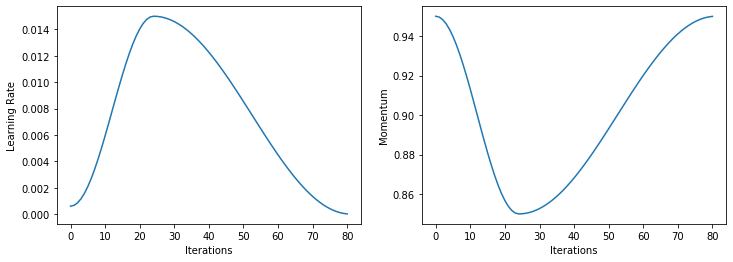

In [14]:
learn.recorder.plot_lr(show_moms=True)

In [16]:
learn = Learner(data = data,
        model = model,
        # opt_func:Callable='Adam',
        loss_func = loss_func,
        metrics = metrics,
        callback_fns=[CSVLogger],
        # true_wd:bool=True,
        # bn_wd:bool=True,
        # wd:Floats=0.01,
        # train_bn:bool=True,
        # path:str=None,
        # model_dir:PathOrStr='models',
        # callback_fns:Collection[Callable]=None,
        # callbacks:Collection[Callback]=<factory>,
        # layer_groups:ModuleList=None,
        # add_time:bool=True,
        # silent:bool=None
        )


In [17]:
learn.fit(3)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.427212,0.462560,0.406562,00:07
1,0.424650,0.443945,0.415111,00:07
2,0.415703,0.438014,0.403081,00:07


In [15]:
learn.fit(3)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.415450,0.421912,0.407842,00:10
1,0.412119,0.419652,0.406406,00:10
2,0.410393,0.419641,0.415870,00:10


In [16]:
learn.fit(3, 1e-1)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.442372,9.325814,1.738970,00:11
1,0.434842,1.561033,0.679737,00:10
2,0.429136,0.512810,0.495250,00:10


In [18]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,mean_absolute_error,time
0,0,0.427212,0.462560,0.406562,00:07
1,1,0.424650,0.443945,0.415111,00:07
2,2,0.415703,0.438014,0.403081,00:07


In [28]:
def fit_odd_shedule(learn, lr):
    n = len(learn.data.train_dl)
    phases = [TrainingPhase(n).schedule_hp('lr', lr, anneal=annealing_cos), 
              TrainingPhase(n*2).schedule_hp('lr', lr, anneal=annealing_poly(2))]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = 3
    learn.fit(total_epochs)

In [31]:
learn = Learner(data = data,
        model = model,
        # opt_func:Callable='Adam',
        loss_func = loss_func,
        metrics = metrics,
#         callback_fns=[CSVLogger],
        # true_wd:bool=True,
        # bn_wd:bool=True,
        # wd:Floats=0.01,
        # train_bn:bool=True,
        # path:str=None,
        # model_dir:PathOrStr='models',
        # callback_fns:Collection[Callable]=None,
        # callbacks:Collection[Callback]=<factory>,
        # layer_groups:ModuleList=None,
        # add_time:bool=True,
        # silent:bool=None
        )
fit_odd_shedule(learn, lr)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.462393,0.493008,0.417751,00:12
1,0.437910,0.422279,0.389722,00:08
2,0.423202,0.410584,0.394305,00:08


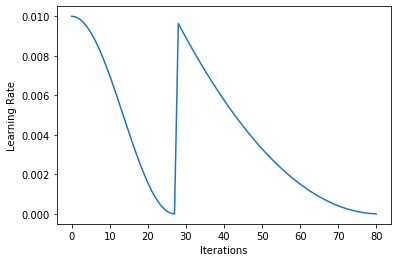

In [32]:
learn.recorder.plot_lr()

In [40]:
learn = Learner(data = data,
        model = model,
        # opt_func:Callable='Adam',
        loss_func = loss_func,
        metrics = metrics,
#         callback_fns=[CSVLogger,
#             SaveModelCallback(learn,
#                         every='epoch',
#                         monitor='valid_loss')],
                
        # true_wd:bool=True,
        # bn_wd:bool=True,
        # wd:Floats=0.01,
        # train_bn:bool=True,
        # path:str=None,
        # model_dir:PathOrStr='models',
        # callback_fns:Collection[Callable]=None,
        # callbacks:Collection[Callback]=<factory>,
        # layer_groups:ModuleList=None,
        # add_time:bool=True,
        # silent:bool=None
        )

In [41]:
learn.fit_one_cycle(3, lr,
        callbacks=[fastai.callbacks.SaveModelCallback(learn, every='epoch', monitor='valid_loss')])

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.418422,0.549371,0.445996,00:08
1,0.414184,0.406664,0.389042,00:08
2,0.408365,0.400928,0.390590,00:08
